In [1]:
import os
import glob
import itertools
import json
import cv2
import sys

import matplotlib as mpl
import scipy.stats as spstats
import pandas as pd
import numpy as np
import seaborn as sns
import pylab as pl
import statsmodels.api as sm
import pingouin as pg

In [2]:
import analyze2p.gratings.utils as gutils
import analyze2p.plotting as pplot
import analyze2p.aggregate_datasets as aggr
import analyze2p.utils as hutils
import analyze2p.receptive_fields.utils as rfutils
import analyze2p.extraction.rois as roiutils
import analyze2p.correlations as cr
import importlib


/n/coxfs01/2p-pipeline/envs/rat2p/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.3.10, the latest is 0.4.0.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs


In [3]:
%matplotlib notebook

In [4]:
#### Plotting params
visual_areas, area_colors = pplot.set_threecolor_palette()
pplot.set_plot_params(labelsize=6, lw_axes=0.25)
bw_colors = dict((v, [0.7]*3) for v in visual_areas)
#### Set trace ID and FOV/state type
aggregate_dir = '/n/coxfs01/julianarhee/aggregate-visual-areas'
rootdir='/n/coxfs01/2p-data'
traceid = 'traces001'
fov_type = 'zoom2p0x'
state = 'awake'

In [5]:
experiment = 'gratings'
responsive_test='ROC'
# ---------------------------------------------------------------
response_type='dff'
responsive_thr=0.05 if responsive_test=='ROC' else 10.0
n_stds=2.5
n_bootstrap_iters=500
print(responsive_test, responsive_thr)
#### Responsive params
ori_fit_desc = gutils.get_fit_desc(response_type=response_type, 
                            responsive_test=responsive_test, 
                            n_stds=n_stds, responsive_thr=responsive_thr, 
                            n_bootstrap_iters=n_bootstrap_iters) #, 
#                             n_resamples=n_resamples)
data_id = '|'.join([traceid, ori_fit_desc])
print(data_id)
#### Set current output dir
dst_dir = os.path.join(aggregate_dir, 'correlations', 
                       'gratings_%s_%s' % (response_type, responsive_test),
                       'pref_theta')
print(dst_dir)

ROC 0.05
traces001|fit-dff_responsive-ROC-thr0.05_boot-500
/n/coxfs01/julianarhee/aggregate-visual-areas/correlations/gratings_dff_ROC/pref_theta


#### Metadata

In [6]:
sdata, cells0 = aggr.get_aggregate_info(visual_areas=visual_areas, return_cells=True)
meta = sdata[sdata.experiment.isin(['gratings'])].copy()
all_dkeys = [(va, dk) for (va, dk), g in meta.groupby(['visual_area', 'datakey'])]

/n/coxfs01/julianarhee/aggregate-visual-areas/dataset_info_assigned.pkl
Segmentation: missing 12 dsets


#### Trial responses

In [7]:
# Load trial metrics
trial_epoch='stimulus'
NDATA0 = aggr.load_responsive_neuraldata(experiment, traceid=traceid,
                      response_type=response_type, trial_epoch=trial_epoch,
                      responsive_test=responsive_test, 
                      responsive_thr=responsive_thr)
if experiment not in ['rfs', 'rfs10']: # assigned in load_responsive_neuraldata()
    NDATA0['experiment'] = experiment 
print("Stimulus: %s (cell counts)" % experiment)
print(NDATA0[['visual_area', 'datakey', 'cell']]\
        .drop_duplicates()['visual_area'].value_counts().to_markdown())
# Get the cells
CELLS = aggr.get_all_responsive_cells(cells0, NDATA0) 
print(CELLS[['visual_area', 'animalid', 'session', 'fovnum']]\
            .drop_duplicates()['visual_area'].value_counts().to_markdown())

/n/coxfs01/julianarhee/aggregate-visual-areas/dataset_info_assigned.pkl
Segmentation: missing 12 dsets
...loading: aggr_gratings_trialmeans_traces001_ROC-thr-0.05_dff_stimulus.pkl
Checking gratings configs
Stimulus: gratings (cell counts)
|    |   visual_area |
|:---|--------------:|
| V1 |           883 |
| Lm |           466 |
| Li |           431 |
|    |   visual_area |
|:---|--------------:|
| Li |            15 |
| Lm |             8 |
| V1 |             8 |


#### Tuning curve fits

In [8]:
gdata, missing_ = gutils.aggregate_ori_fits(CELLS, traceid=traceid, create_new=False,
                            fit_desc=ori_fit_desc, return_missing=True) 
gdata = hutils.split_datakey(gdata)
gdata['tf'] = gdata['sf']*gdata['speed'] # fit params
# Assign "preferred theta" for tested values
tested_thetas = np.arange(0, 360, 45)
theta_vals = np.arange(0, 360+45, 45)
gdata['tested_theta'] = [theta_vals[np.where(np.abs(t-theta_vals)==np.min(np.abs(t-theta_vals)))[0][0]] % 360. \
                            for t in gdata['theta_pref']]
gdata['tested_theta'] = gdata['tested_theta'].astype(float)

#### Only take good fits

In [9]:
best_gof_ixs = gdata.groupby(['visual_area', 'datakey', 'cell'])['gof']\
                    .transform(max) == gdata['gof']
assert gdata.loc[best_gof_ixs].groupby(['visual_area', 'datakey', 'cell'])\
                    .count().max().max()==1
bestg = gdata.loc[best_gof_ixs].copy()

In [10]:
# Unique datasets, get dsets with most ncells pass
min_ncells=0
gof_thr=0.5
drop_repeats=True
counts = aggr.count_n_cells(bestg[bestg['gof']>gof_thr], 
                            name='n_cells', reset_index=True)
print("All cells pass (GoF>%.2f)" % gof_thr)
print(counts.groupby('visual_area').sum().to_markdown())
# Drop duplicates
u_dkeys = aggr.drop_repeats(counts, colname='n_cells')   
FITS = pd.concat([g for (va, dk), g in bestg[bestg['gof']>gof_thr].groupby(['visual_area', 'datakey'])\
          if (va, dk) in u_dkeys])
ncells_fit = aggr.count_n_cells(FITS)
print("Unique datasets (pass, GoF>%.2f)" % gof_thr)
print(ncells_fit.groupby('visual_area').sum().to_markdown())

All cells pass (GoF>0.50)
| visual_area   |   n_cells |
|:--------------|----------:|
| Li            |        90 |
| Lm            |       222 |
| V1            |       444 |
Unique datasets (pass, GoF>0.50)
| visual_area   |   n_cells |
|:--------------|----------:|
| Li            |        62 |
| Lm            |       214 |
| V1            |       444 |


In [11]:
# Drop same duplicates from trial responses
NDATA = pd.concat([g for (va, dk), g \
                   in NDATA0.groupby(['visual_area', 'datakey'])\
                   if (va, dk) in u_dkeys], ignore_index=True)
if 'experiment' not in NDATA.columns:
    NDATA['experiment'] = experiment
# Final counts
final_ncells = aggr.count_n_cells(NDATA)
final_totals = aggr.get_final_cell_and_site_counts(final_ncells)
print("FINAL totals: %s (%s)" % (experiment, responsive_test))
print(final_totals.to_markdown())

FINAL totals: gratings (ROC)
| visual_area   |   n_cells |   datakey |
|:--------------|----------:|----------:|
| Li            |       287 |        10 |
| Lm            |       455 |         7 |
| V1            |       883 |         8 |


<IPython.core.display.Javascript object>


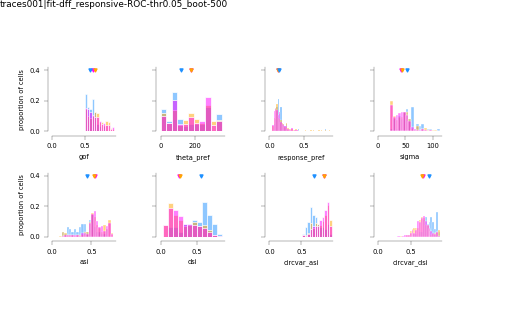

No handles with labels found to put in legend.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


gof                                                    \
             count      mean       std       min       25%       50%   
visual_area                                                            
Li            62.0  0.594653  0.071479  0.500778  0.535308  0.583824   
Lm           214.0  0.667581  0.114639  0.501177  0.571073  0.652739   
V1           444.0  0.651392  0.114105  0.500112  0.556456  0.626588   

                                theta_pref              ... circvar_asi  \
                  75%       max      count        mean  ...         75%   
visual_area                                             ...               
Li           0.633823  0.808742       62.0  153.337722  ...    0.786021   
Lm           0.747107  0.942944      214.0  173.202365  ...    0.903246   
V1           0.727974  0.948377      444.0  172.322118  ...    0.901431   

                      circvar_dsi                                          \
                  max       count      mean       std       min       25%   
visual_area                                                                 
Li           0.934026        62.0  0.778816  0.091882  0.515821  0.717339   
Lm           0.972189       214.0  0.677922  0.114507  0.358982  0.607158   
V1           0.970368       444.0  0.674461  0.106681  0.280241  0.616497   

                                           
                  50%       75%       max  
visual_area                                
Li           0.781053  0.850632  0.928063  
Lm           0.673924  0.744386  0.938331  
V1           0.679016  0.737777  0.916351  

[3 rows x 64 columns]

In [12]:
%matplotlib notebook
means_= FITS.groupby('visual_area').median()
plot_params = ['gof', 'theta_pref',  'response_pref', 'sigma', 
               'asi', 'dsi', 'circvar_asi', 'circvar_dsi']

fig, axn = pl.subplots(2, int(len(plot_params)/2), figsize=(6.5,4),
                      sharey=True)
ylim=0.4
for ax, par in zip(axn.flat, plot_params):
    sns.histplot(x=par, data=FITS, ax=ax,
                 hue='visual_area', hue_order=visual_areas,palette=area_colors, 
                 stat='probability', common_norm=False, edgecolor='w')
    ax.legend_.remove()
    ax.set_xlim([0, ax.get_xlim()[-1]])
    for va, vc in area_colors.items():
        m = float(means_.loc[va, par])
        ax.plot(m, ylim, color=vc, marker='v', markersize=3)
    #ax.set_ylim([0, ylim])
    ax.set_box_aspect(1)
    #ax.set_xlabel(name_lut[par])
    ax.set_ylabel('proportion of cells')
ax.legend(bbox_to_anchor=(1,1), loc='upper left', frameon=False)
pplot.adjust_subplots(bottom=0.25, right=0.85, wspace=0.7)
sns.despine(offset=4)

pplot.label_figure(fig, data_id)
figname = 'hist_per-area_metrics_gof%.2f' % gof_thr
pl.savefig(os.path.join(dst_dir, '%s.svg' % figname))

FITS.groupby(['visual_area'])[plot_params].describe()

In [15]:
FITS.columns

Index(['response_pref', 'response_null', 'theta_pref', 'sigma',
       'response_offset', 'asi', 'dsi', 'circvar_asi', 'circvar_dsi', 'r2',
       'cell', 'r2comb', 'gof', 'sf', 'size', 'speed', 'visual_area',
       'datakey', 'animalid', 'fov', 'session', 'tf', 'tested_theta',
       'experiment'],
      dtype='object')

In [16]:
# Add position info for each cell
FITS['experiment'] = 'gratings'
# FITS = aggr.add_roi_positions(FITS.copy())

In [17]:
response_type='dff'
do_spherical_correction=False
rfdf = rfutils.aggregate_fits(cells0, sdata, combine='average', 
                              response_type=response_type,
                              do_spherical_correction=do_spherical_correction,
                              reliable_only=True,
                              pass_criterion='position')
rfdf = aggr.add_roi_positions(rfdf)

N dpaths: 56, N unfit: 0
N datasets included: 61, N sessions excluded: 4


In [18]:
rfs_with_fits = pd.concat([g for (va, dk), g in rfdf.groupby(['visual_area', 'datakey'])
    if not FITS.query('@va==visual_area and @dk==datakey').empty])


In [19]:
rfs_with_fits.columns

Index(['datakey', 'cell', 'x0', 'y0', 'fwhm_x', 'fwhm_y', 'theta', 'offset',
       'amplitude', 'r2', 'std_x', 'std_y', 'fwhm_avg', 'std_avg', 'area',
       'fx', 'fy', 'ratio_xy', 'theta_c', 'theta_Mm_deg', 'major_axis',
       'minor_axis', 'anisotropy', 'theta_Mm_c', 'aniso_index', 'eccentricity',
       'eccentricity_ctr', 'rf_theta_deg', 'aspect_ratio', 'visual_area',
       'experiment', 'animalid', 'fov', 'session', 'fov_xpos', 'fov_xpos_pix',
       'fov_ypos', 'fov_ypos_pix', 'ml_pos', 'ap_pos'],
      dtype='object')

In [20]:
importlib.reload(cr)

<module 'analyze2p.correlations' from '/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/rat-2p-area-characterizations/analyze2p/correlations.py'>

In [171]:
has_rfs = cr.get_roi_pos_and_rfs(FITS, curr_rfs=rfs_with_fits, rfs_only=False,
                                     merge_cols=['visual_area', 'datakey', 'cell'])


In [172]:
has_rfs

,visual_area,datakey,cell,ml_pos,ap_pos,x0,y0
0,Li,20190314_JC070_fov1,266,612.997260,410.201174,NaN,NaN
1,Li,20190315_JC070_fov2,163,428.336595,493.163209,NaN,NaN
2,Li,20190321_JC070_fov2,59,380.743640,304.194129,NaN,NaN
3,Li,20190522_JC089_fov1,117,144.682583,601.474755,NaN,NaN
4,Li,20190522_JC089_fov1,137,171.334638,306.498630,NaN,NaN
...,...,...,...,...,...,...,...
715,V1,20191006_JC110_fov1,364,380.743640,622.215264,NaN,NaN
716,V1,20191006_JC110_fov1,381,432.144031,518.512720,28.504424,-1.080454
717,V1,20191006_JC110_fov1,384,264.616830,767.398826,23.549118,-0.464498
718,V1,20191006_JC110_fov1,387,270.327984,719.004305,NaN,NaN


In [173]:
fits_and_rfs = pd.merge(FITS, has_rfs, on=['visual_area', 'datakey', 'cell'], 
                        how='outer')
fits_and_rfs.shape

(720, 28)

In [164]:
FITS.shape

(720, 24)

# Tuning curves

In [166]:
importlib.reload(cr)

<module 'analyze2p.correlations' from '/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/rat-2p-area-characterizations/analyze2p/correlations.py'>

In [21]:
dists = cr.aggregate_tuning_curve_ccdist(FITS, rfdf=rfdf, min_ncells=3)

too few cells: Li, 20190314_JC070_fov1
too few cells: Li, 20190315_JC070_fov2
too few cells: Li, 20190321_JC070_fov2
too few cells: Li, 20190617_JC099_fov1
[]


In [22]:
dists.groupby('visual_area').count()

,xcorr,pearsons,cosim,cell_1,cell_2,neuron_pair,rf_distance,max_ecc,min_ecc,cortical_distance,datakey,n_cells
visual_area,,,,,,,,,,,,
Li,373,373,373,373,373,373,89,89,89,373,373,373
Lm,4235,4235,4235,4235,4235,4235,361,361,361,4235,4235,4235
V1,14780,14780,14780,14780,14780,14780,3697,3697,3697,14780,14780,14780


In [27]:
dists.shape, dists.dropna().shape

((19388, 13), (4147, 13))

In [28]:
dists.dropna().groupby('visual_area').count()

,xcorr,pearsons,cosim,cell_1,cell_2,neuron_pair,rf_distance,max_ecc,min_ecc,cortical_distance,datakey,n_cells
visual_area,,,,,,,,,,,,
Li,89,89,89,89,89,89,89,89,89,89,89,89
Lm,361,361,361,361,361,361,361,361,361,361,361,361
V1,3697,3697,3697,3697,3697,3697,3697,3697,3697,3697,3697,3697


In [29]:
dist_params = ['xcorr', 'pearsons', 'cosim', 'cortical_distance', 'rf_distance',
               'n_cells' ]
for p in dist_params:
    dists[p] = dists[p].astype(float)
means_= dists.groupby('visual_area').median()
means_

,xcorr,pearsons,cosim,cell_1,cell_2,rf_distance,max_ecc,min_ecc,cortical_distance,n_cells
visual_area,,,,,,,,,,
Li,0.061404,0.035852,0.716591,50.0,245.0,13.728038,31.788498,25.819638,265.267983,20.0
Lm,0.063903,-0.002722,0.688769,73.0,178.0,13.984402,31.510197,22.423647,397.618254,50.0
V1,0.060633,0.059003,0.712054,91.0,221.5,6.779116,31.033477,25.556234,359.804887,78.0


<IPython.core.display.Javascript object>


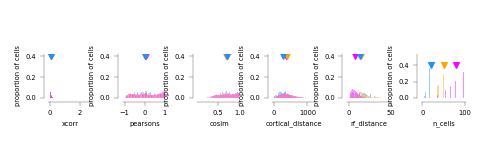

No handles with labels found to put in legend.


In [30]:
%matplotlib notebook
means_= dists.groupby('visual_area').median()
plot_params = dist_params #['xcorr', 'pearsons', 'cosim', 'cortical_distance', 'n_cells' ]
fig, axn = pl.subplots(1,len(plot_params), figsize=(6,2))
ylim=0.4
for ax, par in zip(axn.flat, plot_params):
    sns.histplot(x=par, data=dists, ax=ax,
                 hue='visual_area', hue_order=visual_areas,palette=area_colors, 
                 stat='probability', common_norm=False, edgecolor='w')
    ax.legend_.remove()
    #ax.set_xlim([0, ax.get_xlim()[-1]])
    for va, vc in area_colors.items():
        m = float(means_.loc[va, par])
        ax.plot(m, ylim, color=vc, marker='v')
    #ax.set_ylim([0, ylim])
    ax.set_box_aspect(1)
    #ax.set_xlabel(name_lut[par])
    ax.set_ylabel('proportion of cells')
ax.legend(bbox_to_anchor=(1,1), loc='upper left', frameon=False)
pplot.adjust_subplots(bottom=0.25, right=0.97, wspace=0.7)
sns.despine(offset=4)

# pplot.label_figure(fig, data_id)
# figname = 'hist_per-area_metrics_gof%.2f' % gof_thr
# pl.savefig(os.path.join(dst_dir, '%s.svg' % figname))

# FITS.groupby(['visual_area'])[plot_params].describe()

In [37]:
df = dists.copy()
# Split distances into X um bins
ctx_step=50
ctx_bins = np.arange(0, 1200+ctx_step, ctx_step)
df = cr.cut_bins(df, ctx_bins, 'cortical_distance')

rf_step=5
rf_bins = np.arange(0, 60+rf_step, rf_step)
df = cr.cut_bins(df, rf_bins, 'rf_distance')

In [38]:
import copy

<IPython.core.display.Javascript object>


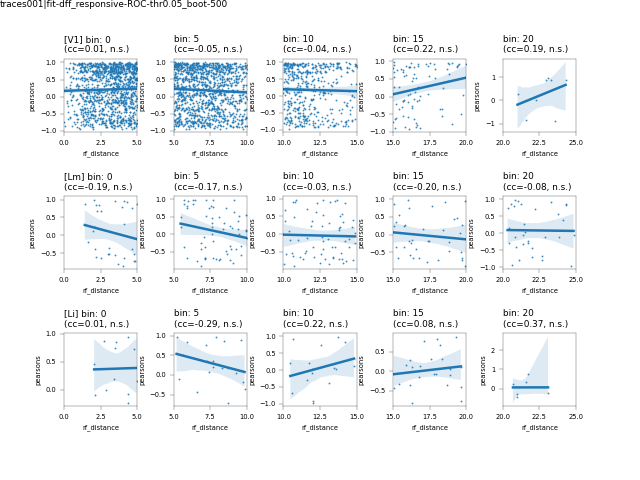

/n/coxfs01/julianarhee/aggregate-visual-areas/correlations/gratings_dff_ROC/pref_theta pearsons_v_binVF_5deg


In [54]:
%matplotlib notebook
y_var='pearsons'
dist_var = 'rf_distance'
# 
dist_str='VF' if dist_var=='rf_distance' else 'CTX'
dist_bins = copy.copy(rf_bins) if dist_var=='rf_distance' else copy.copy(ctx_bins)
dist_step = rf_step if dist_var=='rf_distance' else ctx_step
dist_unit = 'deg' if dist_var=='rf_distance' else 'um'
scatter_kws={'s': 0.5}
n_bins_plot = 5
# --------------------------------------------------------------
# plot
fig, axn = pl.subplots(3, n_bins_plot, figsize=(8,6))
for va, vg in df.groupby('visual_area'):
    vi = visual_areas.index(va)
    for di, (dist_bin, dg) in enumerate(vg.groupby('%s_label' % dist_var)):
        if di >= n_bins_plot:
            continue
        ax = axn[vi, di]
        ax.set_xlim([dist_bins[di], dist_bins[di+1]])
        ax.set_xticks(np.linspace(dist_bins[di], dist_bins[di+1], 3))
        g0 = sns.regplot(data=dg, ax=ax, scatter=True,
                    x=dist_var, y=y_var, scatter_kws=scatter_kws)
        cc, pv = spstats.spearmanr(dg[dist_var].values, dg[y_var].values)
        if pv<0.05:
            sig_str = '**' if pv<0.01 else '*'
        else:
            sig_str = 'n.s.'
        vstr='[%s] ' % va if di==0 else ''
        ax.set_title("%sbin: %i\n(cc=%.2f, %s)" % (vstr,dist_bin, cc, sig_str), 
                     loc='left')
for ax in axn.flat:
    ax.set_box_aspect(1)
pl.subplots_adjust(left=0.1, right=0.9, bottom=0.15, wspace=0.5, hspace=0.8)
pplot.label_figure(fig, data_id)

figname = '%s_v_bin%s_%i%s' % (y_var, dist_str, dist_step, dist_unit)
pl.savefig(os.path.join(dst_dir, '%s.svg' % figname))
print(dst_dir, figname)

In [21]:
importlib.reload(cr)

<module 'analyze2p.correlations' from '/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/rat-2p-area-characterizations/analyze2p/correlations.py'>

In [65]:
# Split distances into X um bins
ctx_step=10
ctx_maxdist = 500
rf_step=2.5
rf_maxdist=60

df = dists[dists.cortical_distance<=ctx_maxdist].copy()
ctx_bins = np.arange(0, ctx_maxdist+ctx_step, ctx_step)
df = cr.cut_bins(df, ctx_bins, 'cortical_distance')
rf_bins = np.arange(0, rf_maxdist+rf_step, rf_step)
df = cr.cut_bins(df, rf_bins, 'rf_distance')

In [66]:
# data = cc_.groupby(x_var).median().reset_index()
# meanvs = cc_.groupby(x_var).median().reset_index().dropna()

# incl_bins = list(set(meanvs[x_var].values))
# incl_bins
# xdata = data[data[x_var].isin(incl_bins)]\
#             .sort_values(by=dist_var)[dist_var].values
# xdata

<IPython.core.display.Javascript object>


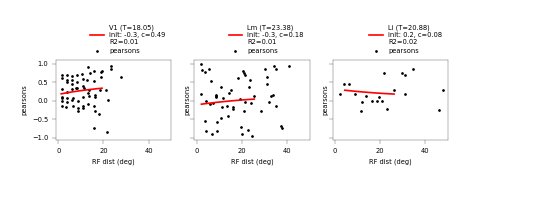

In [74]:
%matplotlib notebook
metric='pearsons'
to_quartile = 'rf_distance'
x_var = '%s_label' % to_quartile

fit_sites = True
use_binned=False
min_npairs = 3
n_iter=int(np.random.rand(1)[0]*500)

xlabel='cortical dist (um)' if to_quartile=='cortical_distance' else 'RF dist (deg)'
cnt_grouper = [x_var] 
if fit_sites:
    cnt_grouper.append('datakey')
   
fig, axn = pl.subplots(1,3, figsize=(7,2.5), sharex=True, sharey=True)
for va, cc0 in df.groupby('visual_area'):
    ax=axn[visual_areas.index(va)]
    cnts = cc0.groupby(cnt_grouper)['neuron_pair'].count()  
    # How many resample per group
    nsamples_per = dict((k, v) for k, v \
                        in zip(cnts[cnts>min_npairs].index.tolist(),
                               cnts[cnts>min_npairs].values))
    # Sample
    cc_ = pd.concat([cg.sample(nsamples_per[c], random_state=n_iter, replace=True) \
                         for c, cg in cc0.groupby(cnt_grouper) \
                         if c in nsamples_per.keys()])
    # fov mean for visualizing
    if fit_sites:
        fit_cc = cc_.groupby(cnt_grouper).median().reset_index().dropna()
    else:
        fit_cc = cc_.copy()
    # plot
    meas_cc = cc0.groupby(cnt_grouper).median().reset_index().dropna()
    ax.scatter(x=to_quartile, y=metric, data=meas_cc, s=2, color='k')
    res_, xvals, yvals = cr.fit_decay_on_binned(fit_cc, use_binned=use_binned,
                                            normalize_x=True, func='halflife',
                                            estimator='median',
                                            metric=metric,
                                            to_quartile=to_quartile,
                                            return_inputs=True)
    if all(res_.isnull()):
        print("BINNED, no fit: %s" % va)
        label='no fit'
    else:
        fit_y = cr.func_halflife(xvals, res_.init, res_.tau, res_.constant)
        label = '%s (T=%.2f)\ninit: %.1f, c=%.2f\nR2=%.2f' \
                        % (va, res_.tau, res_.init, res_.constant, res_.R2)
        ax.plot(xvals, fit_y, color='r', label=label)
    #ax.set_ylim([-0.2, 0.6])
    #ax.set_title(label, loc='left')
    ax.set_ylabel(metric)
    ax.set_xlabel(xlabel)
    ax.legend(bbox_to_anchor=(1,1), loc='lower right', frameon=False, ncol=1)
       #ax.set_title(va)
    #ax.set_xlim([0, 250])
    #ax.set_ylim([0, 0.7])
pl.subplots_adjust(bottom=0.3, left=0.1, right=0.8, top=0.7)

In [39]:
ctx_step=25
max_dist=400

df = dists[dists.cortical_distance<=max_dist].copy()
ctx_dist_bins = np.arange(0, max_dist+ctx_step, ctx_step)
df = cr.cut_bins(df, ctx_dist_bins, metric='cortical_distance')

grp_step=25
grp_bins = np.arange(0, 1000+grp_step, grp_step)
df['distance_group'] = pd.cut(df['cortical_distance'], \
                                                grp_bins, include_lowest=True,
                                                labels=grp_bins[0:-1])
df['distance_group_label'] = [int(d) if not np.isnan(d) else d \
                             for d in df['distance_group'].values]

<IPython.core.display.Javascript object>


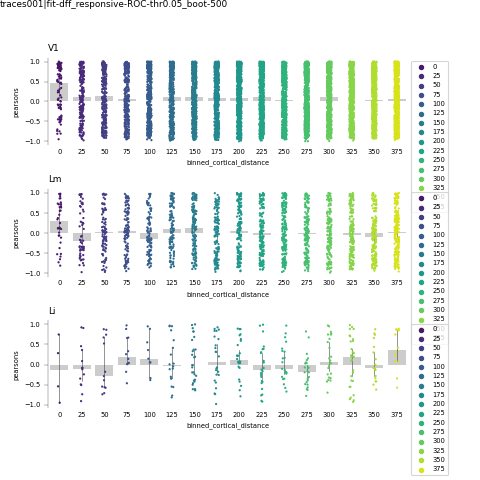

In [40]:
y_var = 'pearsons'
# Ticks
min_npairs=10 #10
sorted_x_vars = [k for k, v in df.groupby(x_var) if k<max_dist]
# Colors
vals_ = grp_bins[grp_bins<=max_dist][0:-1] #np.arange(0, 800+100, 100)
cols_ = sns.color_palette('viridis', n_colors=len(vals_))
grp_colors = dict((k, v) for k, v in zip(vals_, cols_))

fig, axn = pl.subplots(3, 1, figsize=(6,6))
for va, vg in df.groupby('visual_area'):
    ax=axn[visual_areas.index(va)]
    sns.barplot(x='binned_cortical_distance', y=y_var, ax=ax, data=vg,
                color=[0.8]*3, dodge=False, estimator=np.median, errwidth=0.5)
    sns.stripplot(x='binned_cortical_distance', y=y_var, ax=ax, data=vg,
                  hue='distance_group_label', dodge=False, size=2, 
                  palette=grp_colors)
    ax.legend(bbox_to_anchor=(1,1), loc='upper left', markerscale=0.5)
    ax.tick_params(which='both', axis='x', size=0)
    ax.set_title(va, loc='left', fontsize=8)
pl.subplots_adjust(left=0.1, right=0.85, bottom=0.15, hspace=0.5)
sns.despine(bottom=True)

pplot.label_figure(fig, data_id)

0.9324580430984497 3.587015406925076e-10
0.9313173890113831 4.891253693204225e-16


<IPython.core.display.Javascript object>


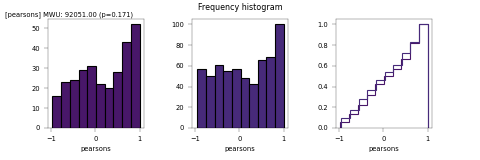

In [42]:
y_var='pearsons'
va='V1'
col1=grp_colors[0]
col2=grp_colors[25]
vg = df[df.visual_area==va].copy()

# v1 = vg[(vg.distance_group_label==0)][y_var].values
# v2 = vg[(vg.distance_group_label==100)][y_var].values
v1 = vg[(vg.binned_cortical_distance.isin([0, 25]))][y_var].values
v2 = vg[(vg.binned_cortical_distance.isin([50, 75]))][y_var].values
# testd = pd.DataFrame({'v1': v1, 'v2': v2})
w, pvalue = spstats.shapiro(v1)
print(w, pvalue)
w, pvalue = spstats.shapiro(v2)
print(w, pvalue)

fig, (ax1, ax2, ax3) = pl.subplots(1, 3, sharex=True, sharey=False, figsize=(6,2))
fig.suptitle('Frequency histogram')
ax1.hist(v1, bins=10, histtype='bar', ec='k', color=col1)
ax2.hist(v2, bins=10, histtype='bar', ec='k', color=col2)
wts1 = np.ones_like(v1)/len(v1)
ax3.hist(v1, bins=10, histtype='step', ec=col1, cumulative=True, weights=wts1)
wts2 = np.ones_like(v2)/len(v2)
ax3.hist(v2, bins=10, histtype='step', ec=col2, cumulative=True,
        weights=wts2)
for ax in fig.axes:
    ax.set_xlabel(y_var)
    
U, p = spstats.mannwhitneyu(x=v1, y=v2, alternative = 'two-sided')
fig.text(0.01, 0.9, '[%s] MWU: %.2f (p=%.3f)' % (y_var, U, p))
pl.subplots_adjust(wspace=0.5, left=0.1, right=0.9, bottom=0.2)

# Tuning curve similarity, test metrics

In [15]:
def cosine_similarity(v1, v2):
    return (v1.dot(v2)) / (np.sqrt(np.sum(v1**2)) * np.sqrt(np.sum(v2**2)))


In [16]:
import analyze2p.gratings.bootstrap_osi as osi

In [17]:
from scipy import signal

In [18]:
params = ['response_pref', 'response_null', 'theta_pref', 'sigma', 'response_offset']   

tested_thetas = np.arange(0, 360, 45)  
n_intervals=3
thetas = osi.interp_values(tested_thetas, n_intervals=n_intervals, wrap_value=360)  

In [19]:
# dists[dists['xcorr']>2]

In [119]:
# va='V1'
# dk='20190511_JC083_fov1'
# r1 = 27
# r2 = 107
# ----------------------
dk ='20190617_JC097_fov1'
va='V1'
# r1 = 203
# r2=399
r1 = 399
r2= 37 #361

fitdf = FITS[(FITS.visual_area==va) & (FITS.datakey==dk)].copy()
fitdf.index = fitdf['cell'].values
ndf = NDATA[(NDATA.visual_area==va) & (NDATA.datakey==dk)].copy()
# adist = dists[(dists.visual_area==va) & (dists.datakey==dk)].copy()

In [120]:
# fig, axn = pl.subplots(1,2)
# ax=axn[0]
# sns.regplot(x='cortical_distance', y='xcorr', data=adist, ax=ax)
# ax=axn[1]
# sns.regplot(x='cortical_distance', y='pearsons', data=adist, ax=ax)

In [121]:
# testd = adist[adist['xcorr']>=2]
# np.union1d(testd['cell_1'].values, testd['cell_2'].values)
# r1=27
# r2 = 107

<IPython.core.display.Javascript object>


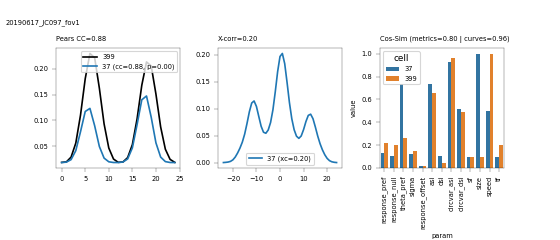

Text(0.01, 0.9, '20190617_JC097_fov1')

In [122]:
%matplotlib notebook
#r1 =27
# r2 = 116
#r2 = 281

popt_r1 = fitdf[params].loc[r1]
fitr1 = osi.double_gaussian(thetas, *popt_r1)

fig, axn = pl.subplots(1,3, figsize=(7,3))
ax=axn[0]
ax.plot(fitr1, label=r1, color='k')

for r2 in [ r2]: #[37, 361, 203]:
    popt_r2 = fitdf[params].loc[r2]
    fitr2 = osi.double_gaussian(thetas, *popt_r2)

    ccorr = signal.correlate(fitr1, fitr2)
    lags = signal.correlation_lags(len(fitr1), len(fitr2))
    cc, pv = spstats.pearsonr(fitr1, fitr2)
    
    axn[0].plot(fitr2, label='%i (cc=%.2f, p=%.2f)' % (r2, cc, pv))
    axn[0].set_title('Pears CC=%.2f' % cc, loc='left', fontsize=6)

    #ax.legend()
    lagzero = list(lags).index(0)
    xcorr = ccorr[lagzero]

    axn[1].plot(lags, ccorr, label='%i (xc=%.2f)' % (r2, xcorr))
    axn[1].set_title('X-corr=%.2f' % xcorr, loc='left', fontsize=6)
    #axn[1].set_ylim([0, 1])

axn[0].legend()
axn[1].legend()

ax=axn[2]
cosim_c = cosine_similarity(fitr1, fitr2)
d0, cosim_m = get_paired_tuning_metrics(fitdf, r1, r2)
sns.barplot(x='param', y='value', hue='cell', data=d0, ax=ax,
           dodge=True)
ax.tick_params(axis='x', rotation=90)
pl.subplots_adjust(bottom=0.5)
ax.set_title('Cos-Sim (metrics=%.2f | curves=%.2f)' % (cosim_m, cosim_c), 
            loc='left', fontsize=6)

pl.subplots_adjust(left=0.1, right=0.9, bottom=0.3, wspace=0.3, top=0.8)

fig.text(0.01, 0.9, dk)

In [25]:
cosine_similarity(fitr1, fitr2)

0.9261705840406864

In [116]:
def get_paired_tuning_metrics(fitdf, r1, r2):
    tuning_params = ['response_pref', 'response_null', 'theta_pref', 'sigma',
                     'response_offset', 'asi', 'dsi', 'circvar_asi', 'circvar_dsi', 
                     'sf', 'size', 'speed', 'tf']
    d_=[]
    for ri in [r1, r2]:
        d1 = pd.DataFrame({'param': fitdf.loc[ri][tuning_params].index.tolist(),
                            'value': fitdf.loc[ri][tuning_params].values})
        d1['cell'] = ri
        d_.append(d1)
    d0 = pd.concat(d_, axis=0)
    cosim_m1 = cosine_similarity(d0[d0['cell']==r1]['value'].values, 
                                d0[d0['cell']==r2]['value'].values)
    # normalize values
    d0.loc[d0.param=='size', 'value'] = d0[d0.param=='size']['value'] /200. 
    d0.loc[d0.param=='speed', 'value'] = d0[d0.param=='speed']['value'] /20. 
    d0.loc[d0.param=='theta_pref', 'value'] = d0[d0.param=='theta_pref']['value'] /360. 
    d0.loc[d0.param=='sigma', 'value'] = d0[d0.param=='sigma']['value'] /180. 
    d0.loc[d0.param=='tf', 'value'] = d0[d0.param=='tf']['value'] /10. 

    cosim_m = cosine_similarity(d0[d0['cell']==r1]['value'].values, 
                                d0[d0['cell']==r2]['value'].values)
    return d0, cosim_m
    #print(cosim_m1, cosim_m)

In [102]:
get_paired_tuning_metrics(fitdf, r1, r2)

0.9857650412181227 0.8582520592249347


In [84]:
fitdf.loc[r1][tuning_params].index

Index(['response_pref', 'response_null', 'theta_pref', 'sigma',
       'response_offset', 'asi', 'dsi', 'circvar_asi', 'circvar_dsi', 'sf',
       'size', 'speed', 'tf'],
      dtype='object')

<IPython.core.display.Javascript object>


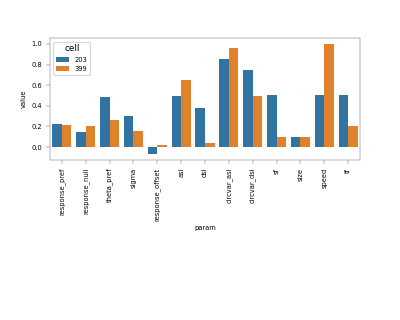

In [95]:
fig, ax = pl.subplots()
sns.barplot(x='param', y='value', hue='cell', data=d0, ax=ax,
           dodge=True)
ax.tick_params(axis='x', rotation=90)
pl.subplots_adjust(bottom=0.5)

In [56]:
cosine_similarity(fitdf.loc[r1][tuning_params], fitdf.loc[r2][tuning_params])


0.9541915669366513

## debug fits

In [113]:
pars = ['gof','sigma', 'asi', 'dsi', 'circvar_asi', 'circvar_dsi', 'sf', 'size', 'speed']

gdata[(gdata.datakey==dk) & (gdata['cell']==107)][pars]

,gof,sigma,asi,dsi,circvar_asi,circvar_dsi,sf,size,speed
2567,0.612545,23.429372,0.723484,0.21754,0.896353,0.690266,0.1,200.0,20.0


In [115]:
fitres, fitparams = gutils.load_tuning_results(dk, fit_desc=ori_fit_desc)


In [118]:
rid = 107
fitres[rid]

{(0.1,
  20.0,
  20): {'results':      response_pref  response_null  theta_pref      sigma  response_offset  \
  0         0.319591       0.224039  275.030744  22.500000         0.250420   
  1         0.251892       0.214297  102.173855  31.469004         0.209163   
  2         0.252955       0.234488   97.092914  26.704377         0.247924   
  3         0.278421       0.165424  104.683387  35.264606         0.197618   
  4         0.261811       0.218827  275.411303  22.500000         0.256697   
  ..             ...            ...         ...        ...              ...   
  495       0.316770       0.251721  110.284715  48.225670         0.055361   
  496       0.229872       0.227676  277.341329  22.500000         0.240974   
  497       0.412286       0.231973  101.613582  51.640699         0.076976   
  498       0.290760       0.252948  273.011817  22.500000         0.228227   
  499       0.235201       0.203375   93.805015  22.590270         0.221040   
  
            asi  

In [121]:
fitres[rid].keys()

dict_keys([(0.1, 20.0, 20), (0.1, 40.0, 20), (0.1, 200.0, 20), (0.5, 20.0, 20), (0.5, 200.0, 20)])

In [122]:
rmetrics, rmetrics_all_cfgs = gutils.get_good_fits(fitres, fitparams, gof_thr=None)


... 97 (of 103) fitable cells (no GoF thr)


In [124]:
rmetrics_all_cfgs[rmetrics_all_cfgs['cell']==rid]

,response_pref,response_null,theta_pref,sigma,response_offset,asi,dsi,circvar_asi,circvar_dsi,r2,cell,r2comb,gof,sf,size,speed
sf-0.10-sz-200-sp-20,0.504464,0.318016,271.836735,23.429372,0.145669,0.723484,0.21754,0.896353,0.690266,0.904699,107,0.534968,0.612545,0.1,200.0,20.0


In [125]:
for stimparam, bootr in fitres[rid].items():
    #r2comb, gof, fitr = gutils.evaluate_fits(bootr, interp=3)
    #print(stimparam, gof)

(0.1, 20.0, 20) nan
(0.1, 40.0, 20) nan
(0.1, 200.0, 20) 0.6125448933397163
(0.5, 20.0, 20) nan
(0.5, 200.0, 20) nan


In [130]:
eparams = [c for c in bootr['results'].columns if 'stim' not in c]
print(eparams)


['response_pref', 'response_null', 'theta_pref', 'sigma', 'response_offset', 'asi', 'dsi', 'circvar_asi', 'circvar_dsi', 'r2', 'cell']


In [152]:
fit_params= ['response_pref', 'response_null', 'theta_pref', 'sigma', 'response_offset']
             
for stimparam, bootr in fitres[rid].items():
    
    fitdf = bootr['results'][eparams]
#     for param in fitdf.columns:
#         if 'theta' in param:
#             cnts, bns = np.histogram(fitdf[param] % 360., bins=np.linspace(0, 360., 50)) 
#             meanval = float(bns[np.where(cnts==max(cnts))[0][0]])  
#         else:
#             meanval = fitdf[param].mean()
#         print(param, meanval)
    avg_metrics = gutils.average_metrics_across_iters(bootr['results'][eparams])
    #print(stimparam, avg_metrics)
    orig_ = bootr['data']['responses'].mean(axis=0).copy()
    if orig_.min()<0:
        print(stimparam, 'neg.')
        orig_ -= orig_.min()
    origr = gutils.interp_values(orig_)   
    thetas = bootr['fits']['xv']
    cpopt = tuple(avg_metrics[fit_params].values[0])
    fitr = gutils.double_gaussian( thetas, *cpopt) 
    r2_comb, _ = gutils.coeff_determination(origr, fitr)
    iqr = spstats.iqr(bootr['results']['r2'])          
    gfit = np.mean(bootr['results']['r2']) * (1-iqr) * np.sqrt(r2_comb) 
    print(stimparam, gfit)

0.1968532985056689
(0.1, 20.0, 20) 0.4967150432314194
0.09582170304881409
(0.1, 40.0, 20) 0.836783415282605
0.09684316594010572
(0.1, 200.0, 20) 0.8047953761626189
0.3399764977173693
(0.5, 20.0, 20) nan
0.14527391384274382
(0.5, 200.0, 20) 0.270802526259742


In [160]:
stimparam = (0.5, 20.0, 20)
bootr = fitres[rid][stimparam]
avg_metrics = gutils.average_metrics_across_iters(bootr['results'][eparams])
orig_ = bootr['data']['responses'].mean(axis=0).copy()
origr = gutils.interp_values(orig_)   
thetas = bootr['fits']['xv']
cpopt = tuple(avg_metrics[fit_params].values[0])
fitr = gutils.double_gaussian( thetas, *cpopt) 
r2_comb, _ = gutils.coeff_determination(origr, fitr)

In [162]:
iqr = spstats.iqr(bootr['results']['r2'])          
gfit = np.mean(bootr['results']['r2']) * (1-iqr) * np.sqrt(r2_comb) 

In [165]:
np.mean(bootr['results']['r2'])

0.8003723260982941

In [166]:
(1-iqr)

0.8565975455384629

In [169]:
dk

'20190511_JC083_fov1'

<IPython.core.display.Javascript object>


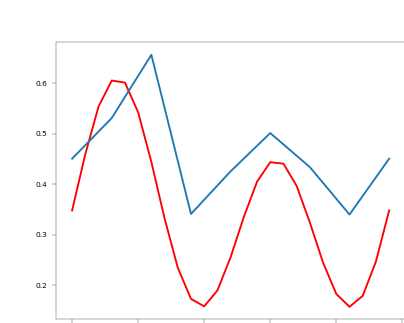

In [161]:
fig, ax = pl.subplots()
ax.plot(fitr, 'r')
ax.plot(origr)

In [151]:
bootr['data']['responses'].mean(axis=0).min()

0.14527391384274382

In [136]:
cnts, bns = np.histogram(fitdf[param] % 360., bins=np.linspace(0, 360., 50)) 
float(bns[np.where(cnts==max(cnts))[0][0]])  

249.79591836734696

In [139]:
avg_metrics = gutils.average_metrics_across_iters(bootr['results'][eparams])
avg_metrics

,response_pref,response_null,theta_pref,sigma,response_offset,asi,dsi,circvar_asi,circvar_dsi,r2,cell
107,0.251711,0.134647,249.795918,58.8425,0.016991,0.348899,0.604985,0.873725,0.944883,0.77321,107.0


# Calcualte point differences

In [63]:
angdists = cr.aggregate_angular_dists(FITS, min_ncells=5)

too few cells: Li, 20190314_JC070_fov1
too few cells: Li, 20190315_JC070_fov2
too few cells: Li, 20190321_JC070_fov2
too few cells: Li, 20190522_JC089_fov1
too few cells: Li, 20190617_JC099_fov1
too few cells: Li, 20191105_JC117_fov1
too few cells: Li, 20191111_JC120_fov1
too few cells: Lm, 20191105_JC117_fov1


In [64]:
df = angdists.copy()

<IPython.core.display.Javascript object>


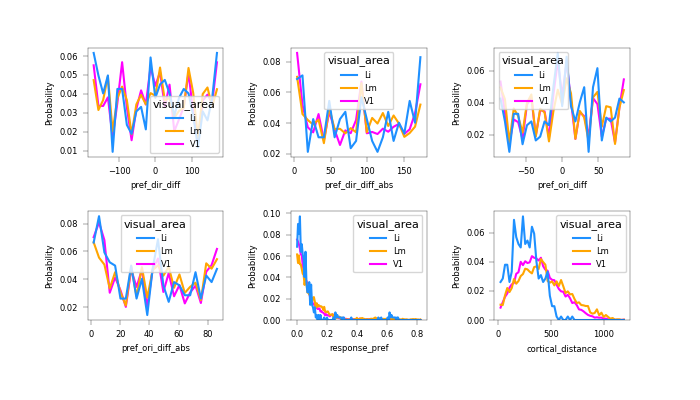

In [65]:
%matplotlib notebook
# plotd = angdists.copy()
plotd = df.dropna().copy()
plot_list = ['pref_dir_diff', 'pref_dir_diff_abs', 
             'pref_ori_diff', 'pref_ori_diff_abs','response_pref',
            'cortical_distance']
fig, axn =pl.subplots(2, int(len(plot_list)/2), figsize=(7,4))
for ax, par in zip(axn.flat, plot_list):
    sns.histplot(x=par, data=plotd, ax=ax, common_norm=False,
            hue='visual_area', palette=area_colors, stat='probability',
            element='poly', fill=False)
pl.subplots_adjust(bottom=0.2, wspace=0.5, hspace=0.5)

In [59]:
np.arange(0, )

array([], dtype=int64)

In [67]:
# Split distances into X um bins
ctx_step=50
ctx_bins = np.arange(0, 1200+ctx_step, ctx_step)
df = cr.cut_bins(df, ctx_bins, 'cortical_distance')

<IPython.core.display.Javascript object>


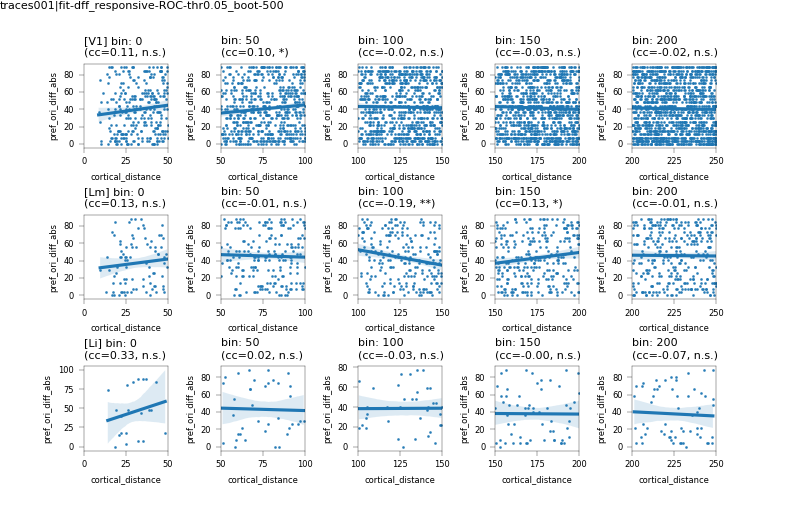

/n/coxfs01/julianarhee/aggregate-visual-areas/correlations/gratings_dff_ROC/pref_theta pref_ori_diff_abs_v_binCTX_50um


In [80]:
%matplotlib notebook
y_var='pref_ori_diff_abs'
dist_var = 'cortical_distance'
scatter_kws={'s': 1}
n_bins_plot = 5
# --------------------------------------------------------------
# plot
fig, axn = pl.subplots(3, n_bins_plot, figsize=(8,5.3))
for va, vg in df.groupby('visual_area'):
    vi = visual_areas.index(va)
    for di, (dist_bin, dg) in enumerate(vg.groupby('%s_label' % dist_var)):
        if di >= n_bins_plot:
            continue
        ax = axn[vi, di]
        ax.set_xlim([ctx_bins[di], ctx_bins[di+1]])
        ax.set_xticks(np.linspace(ctx_bins[di], ctx_bins[di+1], 3))
        g0 = sns.regplot(data=dg, ax=ax, scatter=True,
                    x=dist_var, y=y_var, scatter_kws=scatter_kws)
        cc, pv = spstats.spearmanr(dg[dist_var].values, dg[y_var].values)
        if pv<0.05:
            sig_str = '**' if pv<0.01 else '*'
        else:
            sig_str = 'n.s.'
        vstr='[%s] ' % va if di==0 else ''
        ax.set_title("%sbin: %i\n(cc=%.2f, %s)" % (vstr,dist_bin, cc, sig_str), 
                     loc='left')
for ax in axn.flat:
    ax.set_box_aspect(1)
pl.subplots_adjust(left=0.1, right=0.9, bottom=0.15, wspace=0.5, hspace=0.8)
pplot.label_figure(fig, data_id)

figname = '%s_v_binCTX_%ium' % (y_var, ctx_step)
pl.savefig(os.path.join(dst_dir, '%s.svg' % figname))
print(dst_dir, figname)

## Compare with signal corrs

In [81]:
SDF = aggr.check_sdfs(NDATA['datakey'].unique(), experiment=experiment,
                      images_only=False,rename=False, 
                      return_incorrect=False, return_all=False)
select_stimuli='fullfield'
distance_var = 'rf_distance'
min_ncells=10
CORRS = cr.aggregate_ccdist(NDATA, experiment=experiment, rfdf=None,
                        SDF=SDF, select_stimuli=select_stimuli,min_ncells=min_ncells,
                        distance_var=distance_var, verbose=True)

Checking gratings configs
Dist: cortical_distance
Skipping - (Li, 20190321_JC070_fov2)
Skipping - (Li, 20191105_JC117_fov1)
Skipping - (Lm, 20191105_JC117_fov1)
8 datasets w wrong configs:
    ('Li', '20190314_JC070_fov1')
    ('Li', '20190315_JC070_fov2')
    ('Li', '20190522_JC089_fov1')
    ('Lm', '20190306_JC061_fov2')
    ('Lm', '20190512_JC083_fov1')
    ('Lm', '20190513_JC078_fov1')
    ('V1', '20190511_JC083_fov1')
    ('V1', '20190512_JC083_fov1')
0 datasets w/out RF fits:


In [83]:
ign_cols =  ['experiment', 'signal_cc', 'noise_cc', 'n_cells']
cc_cols = [k for k in CORRS.columns if k not in ign_cols]
# DF = pd.merge(angdists, ccdf, on=cc_cols, how='inner')
ccdf = pd.merge(angdists, CORRS, on=cc_cols, how='inner')

In [ ]:
# 

In [91]:
df = ccdf.copy()

In [92]:
# Split distances into X um bins
ctx_step=50
ctx_bins = np.arange(0, 1200+ctx_step, ctx_step)
df = cr.cut_bins(df, ctx_bins, 'cortical_distance')

In [86]:
angdists.shape

(19409, 13)

<IPython.core.display.Javascript object>


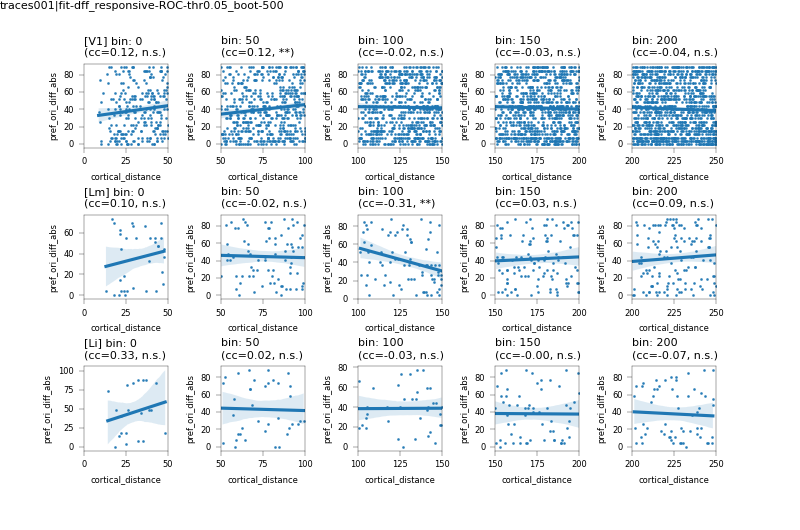

/n/coxfs01/julianarhee/aggregate-visual-areas/correlations/gratings_dff_ROC/pref_theta pref_ori_diff_abs_v_binCTX_50um_cc


In [93]:
%matplotlib notebook
y_var='pref_ori_diff_abs'
dist_var = 'cortical_distance'
scatter_kws={'s': 1}
n_bins_plot = 5
# --------------------------------------------------------------
# plot
fig, axn = pl.subplots(3, n_bins_plot, figsize=(8,5.3))
for va, vg in df.groupby('visual_area'):
    vi = visual_areas.index(va)
    for di, (dist_bin, dg) in enumerate(vg.groupby('%s_label' % dist_var)):
        if di >= n_bins_plot:
            continue
        ax = axn[vi, di]
        ax.set_xlim([ctx_bins[di], ctx_bins[di+1]])
        ax.set_xticks(np.linspace(ctx_bins[di], ctx_bins[di+1], 3))
        g0 = sns.regplot(data=dg, ax=ax, scatter=True,
                    x=dist_var, y=y_var, scatter_kws=scatter_kws)
        cc, pv = spstats.spearmanr(dg[dist_var].values, dg[y_var].values)
        if pv<0.05:
            sig_str = '**' if pv<0.01 else '*'
        else:
            sig_str = 'n.s.'
        vstr='[%s] ' % va if di==0 else ''
        ax.set_title("%sbin: %i\n(cc=%.2f, %s)" % (vstr,dist_bin, cc, sig_str), 
                     loc='left')
for ax in axn.flat:
    ax.set_box_aspect(1)
pl.subplots_adjust(left=0.1, right=0.9, bottom=0.15, wspace=0.5, hspace=0.8)
pplot.label_figure(fig, data_id)

figname = '%s_v_binCTX_%ium_cc' % (y_var, ctx_step)
pl.savefig(os.path.join(dst_dir, '%s.svg' % figname))
print(dst_dir, figname)

In [119]:
df = ccdf.copy()
# --------------------------------------------------
metric = 'pref_ori_diff_abs'
m_bins = np.linspace(0, 90, 9)
df = cr.cut_bins(df, m_bins, metric=metric)

ctx_step=12.5
ctx_bins = np.arange(0, 1200+ctx_step, ctx_step)
df = cr.cut_bins(df, ctx_bins, 'cortical_distance')